In [1]:
import numpy as np
import tensorflow as tf
import time
import h5py
# from Network.PatchHandler3D import PatchHandler3D
from Network.PatchHandler3D_temporal import PatchHandler4D
from test_iterator import check_compatibility, load_indexes
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
from IPython.display import display
from utils.evaluate_utils import *
from scipy.ndimage import binary_erosion
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prepare_data.h5functions import save_to_h5
import matplotlib
import matplotlib.animation as animation
plt.rcParams['figure.figsize'] = [10, 8]
from utils.colors import *


In [7]:
vel_colnames = ['u', 'v','w']
venc_colnames = [ 'u_max', 'v_max', 'w_max']
mag_colnames = [ 'mag_u', 'mag_v', 'mag_w']

In [2]:

dynamical_mask = '../data/CARDIAC/M2_2mm_step2_static_dynamic.h5'
noisy_downsampled = '../data/CARDIAC/M2_2mm_step2_static_dynamic_noise.h5'
# dynamical_mask = '../data/CARDIAC/M2_2mm_step2_invivoP04_magnitude.h5'
# noisy_downsampled = '../data/CARDIAC/M2_2mm_step2_invivoP04_magnitude_noisy.h5'
data_original = {}
data_2 = {}
vel_colnames = ['u', 'v','w']
venc_colnames = [ 'u_max', 'v_max', 'w_max']
mag_colnames = [ 'mag_u', 'mag_v', 'mag_w']
vencs = {}

with h5py.File(dynamical_mask, mode = 'r' ) as p1:
    with h5py.File(noisy_downsampled, mode = 'r' ) as p2:
            print(p1.keys())
            mask =  np.asarray(p1['mask'])
            temporal_mask = mask.copy()
            data_original['mask'] = temporal_mask
            data_2['mask'] = np.asarray(p2['mask']).squeeze()#create_temporal_mask(np.asarray(p2['mask']).squeeze(), p2['u'].shape[0])
            # temporal_mask = create_temporal_mask(mask.squeeze(), p1['u'].shape[0])
            for vel, venc, mag in zip(vel_colnames, venc_colnames, mag_colnames):
                data_original[vel] = np.asarray(p1[vel])/np.max(p1[venc])
                data_2[vel] = np.asarray(p2[vel])/np.max(p1[venc])

                data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], temporal_mask)
                data_2[f'{vel}_fluid']  = np.multiply(data_2[vel] , temporal_mask)
                data_original[mag] = np.asarray(p1[mag])
                data_2[mag] = np.asarray(p2[mag])

           

print(data_original['mask'].shape, data_2['mask'].shape)
with h5py.File('../results/Temporal4DFlowNet_20230313-0951/Testset_result_model4_2mm_step2_0951_temporal.h5', mode = 'r' ) as test1:
     print(test1['u_combined'].shape)

N_frames = data_original['u'].shape[0]
print("Max val:", np.max(data_original['u']), np.max(data_original['v']), np.max(data_original['w']))
print("Min val:", np.min(data_original['u']), np.min(data_original['v']), np.min(data_original['w']))

<KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>
(50, 84, 60, 96) (50, 84, 60, 96)
(50, 62, 58, 84)
Max val: 0.29464915 1.0 1.0
Min val: -1.0 -0.834128 -0.37590972


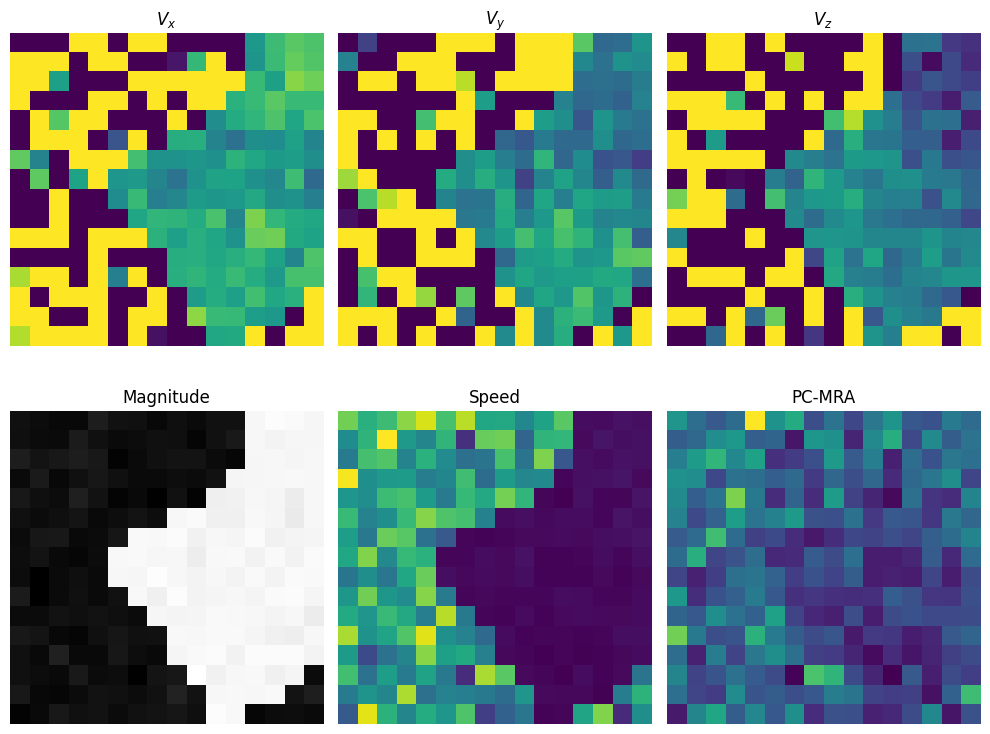

In [7]:
magn = np.sqrt(data_2['mag_u']**2 + data_2['mag_v']**2 + data_2['mag_w']**2)
speed = np.sqrt(data_2['u']**2 + data_2['v']**2 + data_2['w']**2)
pc_mri = np.multiply(magn, speed)

min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

idx_slice = np.index_exp[5, -30:-14, 30, 3:19]


plt.subplot(2, 3, 1)
plt.imshow(data_2['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
# plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
plt.title(r'$V_x$')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(data_2['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
# plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
plt.title(r'$V_y$')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(data_2['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
# plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
plt.title(r'$V_z$')
plt.axis('off')



plt.subplot(2, 3, 4)
plt.imshow(magn[idx_slice], cmap='Greys_r')
plt.title('Magnitude')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(speed[idx_slice])
plt.title('Speed')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(pc_mri[idx_slice])
plt.title('PC-MRA')
plt.axis('off')


plt.tight_layout()



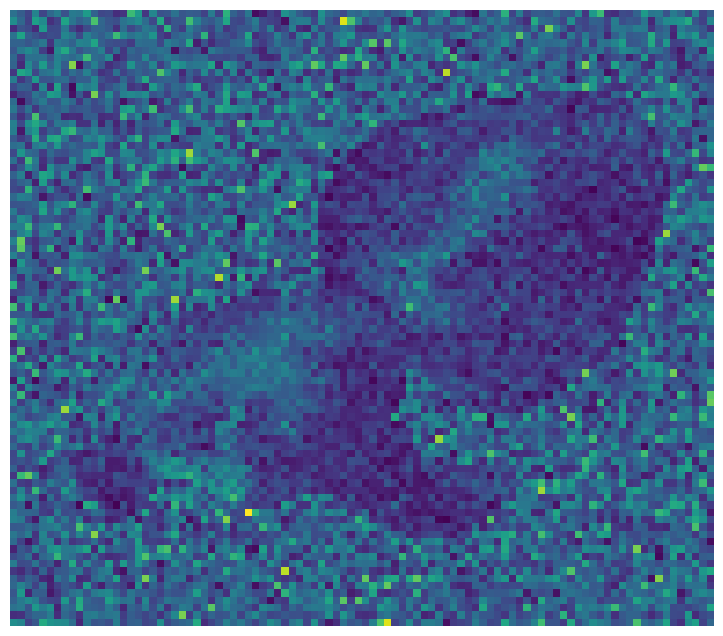

In [11]:
eval_dir = '../results/data'

idx_slice = np.index_exp[5, :, 30, :]


plt.imshow(data_2['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
# plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_u.png', bbox_inches='tight')


plt.imshow(data_2['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
# plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_v.png',bbox_inches='tight')


plt.imshow(data_2['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
# plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_w.png', bbox_inches='tight')


plt.imshow(magn[idx_slice], cmap='Greys_r')
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_mag.png', bbox_inches='tight')

plt.imshow(speed[idx_slice])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_speed.png', bbox_inches='tight')

plt.imshow(pc_mri[idx_slice])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_pcmri.png', bbox_inches='tight')

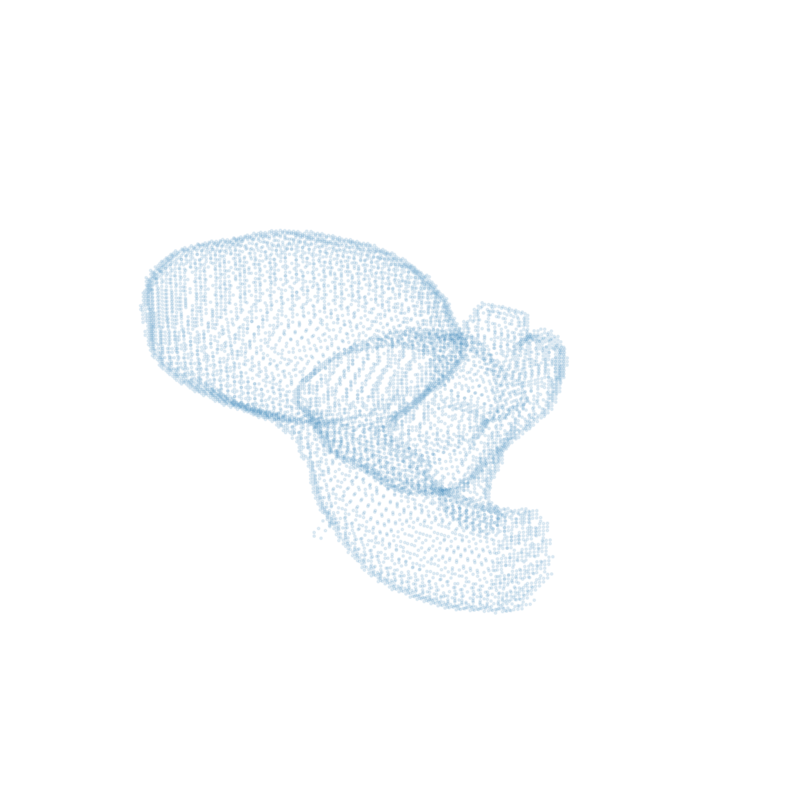

In [3]:
frame = 5
bounds, core_mask = get_boundaries(data_original['mask'])
#get points for plotting model
x_bounds, y_bounds, z_bounds = np.where(bounds[frame, :, :,:]==1)

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_axis_off()
ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.savefig('../results/data/M4_3D.png')
# ax.view_init(5, 70)

In [ ]:
frame_i = 10
u1_i_fluid = data_original['u'][frame_i][np.where(data_original['mask'][frame_i] ==1)]
u2_i_fluid = data_2['u'][frame_i][np.where(data_original['mask'][frame_i] ==1)]
# print(u1_i_fluid.shape)
# print('gt SNR:',        signaltonoise(normalize_to_0_1(u1_i_fluid), axis=(0)))
# print('noisy SNR :',    signaltonoise(normalize_to_0_1(u2_i_fluid), axis=(0)))
# print('gt SNR db:',     signaltonoise_db(normalize_to_0_1(u1_i_fluid), axis=(0)))
# print('noisy SNR db:',  signaltonoise_db(normalize_to_0_1(u2_i_fluid), axis=(0)))


# print('PSNR db:', peak_signal_to_noise_ratio(data_1['u'][10], data_2['u'][10]), cv2_psnr(data_1['u'][10], data_2['u'][10]))

# print('SNR :', signaltonoise(data_1['u'][10], axis=(0, 1, 2)))
# snr_u_gt =    [signaltonoise_fluid_region(data_1['u'][frame], data_1['mask'][frame]) for frame in range(N_frames)]
# snr_v_gt =    [signaltonoise_fluid_region(data_1['v'][frame], data_1['mask'][frame]) for frame in range(N_frames)]
# snr_w_gt =    [signaltonoise_fluid_region(data_1['w'][frame], data_1['mask'][frame]) for frame in range(N_frames)]

snr_u_noisy = [signaltonoise_fluid_region(data_2['u'][frame], data_original['mask'][frame]) for frame in range(N_frames)]
snr_v_noisy = [signaltonoise_fluid_region(data_2['v'][frame], data_original['mask'][frame]) for frame in range(N_frames)]
snr_w_noisy = [signaltonoise_fluid_region(data_2['w'][frame], data_original['mask'][frame]) for frame in range(N_frames)]
plt.figure(figsize=(8, 4))

plt.plot(snr_u_noisy,'--', label= 'u noisy')
plt.plot(snr_v_noisy,'--', label= 'v noisy')
plt.plot(snr_w_noisy,'--', label= 'w noisy')
# plt.plot(snr_u_gt,  label= 'u gt')
# plt.plot(snr_v_gt,  label= 'v gt')
# plt.plot(snr_w_gt,  label= 'w gt')
plt.legend()
plt.xlabel('frame')
plt.ylabel('SNR mean/std')

In [ ]:
# look at sinc interpolation
upsampled_sinc ='../data/CARDIAC/M4_2mm_step2_static_dynamic_noise_sinc.h5'
noisy_downsampled = '../data/CARDIAC/M4_2mm_step2_static_dynamic_noise.h5'
data_original = {}
data_2 = {}
vel_colnames = ['u', 'v','w']

with h5py.File(noisy_downsampled, mode = 'r' ) as p1:
    data_original['mask'] =  np.asarray(p1['mask'])
    temporal_mask = np.asarray(data_original['mask']).squeeze().copy()
    for vel in vel_colnames:
        data_original[vel] = np.asarray(p1[vel])
        data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], temporal_mask)

with h5py.File(upsampled_sinc, mode = 'r' ) as p2:
    data_2['mask'] =  temporal_mask
    for vel in vel_colnames:
        data_2[vel] = np.asarray(p2[vel]).squeeze()



In [ ]:
print(temporal_mask.shape)
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

### In vivo data visualization

In [3]:
# look at in vivo data
in_vivo = '../data/PIA/BARCELONA/h5/sample_patient_newmask.h5'
# in_vivo_upsampled = '../data/PIA/BARCELONA/h5/sample_patient.h5'
in_vivo_upsampled = '../results/in_vivo/BARCELONA/20230405-1417_temporal.h5' # _newshape
# in_vivo = '../data/PIA/THORAX/P01/h5/P01.h5'
# in_vivo_upsampled = '../results/in_vivo/THORAX/P01_20230405-1417_temporal.h5' #image.png
data_original = {}
data_predicted = {}
vencs = {}
vel_colnames = ['u', 'v','w']
mag_colnames = ['mag_u', 'mag_v', 'mag_w']
venc_colnames = [  'u_max', 'v_max', 'w_max']



#load in-vivo data
with h5py.File(in_vivo, mode = 'r' ) as p1:
    data_original['mask'] =  np.asarray(p1['mask']).squeeze()
    print(p1.keys())
    for vel, venc in zip(vel_colnames, venc_colnames):
        vencs[venc] = np.asarray(p1[venc])
        data_original[vel] = np.asarray(p1[vel], dtype = float).squeeze()/np.max(p1[venc]) #TODO change this
        data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], data_original['mask'])
    for mag in mag_colnames:
         data_original[mag] =  np.asarray(p1[mag]).squeeze()

#load prediction
with h5py.File(in_vivo_upsampled, mode = 'r' ) as h_pred:
    for vel, venc in zip(vel_colnames, venc_colnames):
        data_predicted[vel] = np.asarray(h_pred[f'{vel}_combined']) /np.max(vencs[venc]) 
        # add information considering only the fluid regions  
        data_predicted[f'{vel}_fluid'] =np.multiply(data_predicted[vel], data_original['mask'])
        
# print(data_predicted['u'].shape, data_1['u'].shape)
N_frames = data_original['u'].shape[0]
print("Max val:", np.max(data_original['u']), np.max(data_original['v']), np.max(data_original['w']))
print("Min val:", np.min(data_original['u']), np.min(data_original['v']), np.min(data_original['w']))

# print(np.linalg.norm(data_1['mask']- data_predicted['mask']))

<KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>
Max val: 1.0 0.9995219885277247 0.961789375582479
Min val: -0.9240053643272239 -1.0 -1.0


In [ ]:

print('pred SNR:', signaltonoise(normalize_to_0_1(data_predicted['u'][10]), axis=(0, 1, 2)))
print('noisy SNR :', signaltonoise(normalize_to_0_1(data_original['u'][10]), axis=(0, 1, 2)))
print('pred SNR db:', signaltonoise_db(normalize_to_0_1(data_predicted['u'][10]), axis=(0, 1, 2)))
print('noisy SNR db:', signaltonoise_db(normalize_to_0_1(data_original['u'][10]), axis=(0, 1, 2)))
snr_u_input = [signaltonoise_db(normalize_to_0_1(data_original['u'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_v_input = [signaltonoise_db(normalize_to_0_1(data_original['v'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_w_input = [signaltonoise_db(normalize_to_0_1(data_original['w'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_u_sr =    [signaltonoise_db(normalize_to_0_1(data_predicted['u'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_v_sr =    [signaltonoise_db(normalize_to_0_1(data_predicted['v'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_w_sr =    [signaltonoise_db(normalize_to_0_1(data_predicted['w'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
plt.figure(figsize=(8, 4))
plt.plot(snr_u_input,'--', label= 'u in-vivo')
plt.plot(snr_v_input,'--', label= 'v in-vivo')
plt.plot(snr_w_input,'--', label= 'w in-vivo')
plt.plot(snr_u_sr, label= 'u predicted')
plt.plot(snr_v_sr, label= 'v predicted')
plt.plot(snr_w_sr, label= 'w predicted')
plt.legend()
plt.xlabel('frame')
plt.ylabel('SNR mean/std')

In [ ]:
def temporal_linear_interpolation_np_test(lr, hr_shape):
    T, x, y, z = hr_shape
    interpolate = np.zeros((hr_shape))
    interpolate[::2, :, :, :] = lr
    for t in range(0, T-2, 2):
        interpolate[1+t, :, :, :] = (interpolate[t, :, :, :] + interpolate[1+t+1, :, :, :]) /2

    return interpolate

In [4]:
#find lower and higher values to display velocity fields
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(data_original['mask'] !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(data_original['mask'] !=0)].flatten(), 0.99)

In [ ]:


# interpolate data (take every second slice and interpolate them)
interpolate_linear = {}
interpolate_cubic = {}
for vel in vel_colnames:
    interpolate_linear[vel] = temporal_linear_interpolation_np_test(data_original[vel][::2], data_original[vel].shape)
    interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], data_original['mask'])

    # interpolate_cubic[vel] = temporal_cubic_interpolation(data_1[vel][::2], data_1[vel].shape)
    # interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], data_1['mask'])

error_pointwise, error_absolut = calculate_pointwise_error(data_predicted["u"], data_predicted["v"], data_predicted["w"], data_original["u"], data_original["v"] , data_original["w"], data_original["mask"])

# visualize given data
magn = np.sqrt(data_original['mag_u']**2 + data_original['mag_v']**2 + data_original['mag_w']**2)

## Visualize in - vivo data

In [34]:
# look at in vivo data
in_vivo_oldmask = '../data/PIA/BARCELONA/BARCELONA2/h5/case_004.h5'
data_original = {}

#load in-vivo data
with h5py.File(in_vivo_oldmask, mode = 'r' ) as p1:
    for vel in vel_colnames:
        data_original[vel] = np.array(p1[vel]).squeeze() 
    for mag in mag_colnames:
        data_original[mag] = np.array(p1[mag]).squeeze() 
    print(p1.keys())
    data_original['mask'] =  np.asarray(p1['mask']).squeeze()  
    for key in p1.keys():
        print(key, 'shape', p1[key].shape)
    
    # print(np.array(p1['v_max']))

# print('Norm loaded masks:', np.linalg.norm(data_original['mask']- data_original['mask_old']))


@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.figure(figsize=(10, 10))
    N  =3
    plt.subplot(1, N, 1)
    plt.imshow(data_original['u'][frame, x, :, :])#, vmin=min_v['u'],  vmax = max_v['u'])
    plt.title('Data, u')
    plt.axis('off')

    # plt.subplot(1, N, 2)
    # plt.imshow(data_original['u_fluid'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    # plt.title('new mask')
    # plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(data_original['mag_u'][frame, x, :, :])
    plt.title('mag')
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(data_original['mask'][frame, x, :, :])#-data_original['mask'][frame, x, :, :])
    plt.title('mask')
    plt.axis('off')

    # plt.subplot(1, 4, 3)
    # plt.imshow(magn[frame, x, :, :], cmap ='Greys')#,vmin=min_v['u'], vmax = max_v['u'])
    # plt.title('magnitude')
    # plt.axis('off')

    # plt.subplot(1, 4, 4)
    # plt.imshow(data_1['mask'][frame, x, :, :], cmap ='Greys')#,vmin=min_v['u'], vmax = max_v['u'])
    # plt.title('mask')
    # plt.axis('off')
    # plt.show()

<KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>
dx shape (1, 3)
mag_u shape (30, 144, 178, 256)
mag_v shape (30, 144, 178, 256)
mag_w shape (30, 144, 178, 256)
mask shape (30, 144, 178, 256)
u shape (30, 152, 178, 256)
u_max shape (30, 1)
v shape (30, 152, 178, 256)
v_max shape (30, 1)
w shape (30, 152, 178, 256)
w_max shape (30, 1)


interactive(children=(IntSlider(value=5, description='frame', max=29), IntSlider(value=0, description='x', max…

In [ ]:
print('Norm loaded masks:', np.linalg.norm(data_original['mask']- data_original['mask_old']))

# make mask from predicted region
mask_predicted = np.zeros_like(data_predicted['v'])
mask_predicted[np.where(data_predicted['v'] !=0)]

print('Norm predicted mask and loaded mask', np.linalg.norm(data_original['mask']- mask_predicted))

#### Show comparison of prediction and original data

In [ ]:

@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    idx_slice = np.index_exp[frame, x, :, :]

    

    plt.subplot(3, 4, 1)
    plt.imshow(data_original['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    # plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    plt.title('u')
    plt.axis('off')

    plt.subplot(3, 4, 2)
    plt.imshow(data_original['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    # plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    plt.title('v')
    plt.axis('off')

    plt.subplot(3, 4, 3)
    plt.imshow(data_original['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    # plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    plt.title('w')
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(data_original['mask'][idx_slice], cmap ='Greys')
    plt.title('mask')
    plt.axis('off')
    
    plt.subplot(3, 4, 5)
    plt.imshow(data_predicted['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    plt.title('u predicted')
    plt.axis('off')

    plt.subplot(3, 4, 6)
    plt.imshow(data_predicted['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    plt.title('v predicted')
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(data_predicted['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    plt.title('w predicted')
    plt.axis('off')

    plt.subplot(3, 4, 8)
    plt.imshow(magn[idx_slice], cmap ='Greys')
    plt.title('magnitude')
    plt.axis('off')

    plt.subplot(3, 4, 9)
    plt.imshow(np.abs(data_original['u_fluid'][idx_slice]- data_predicted['u_fluid'][idx_slice]), vmin = min_v['u'], vmax = max_v['u'], cmap = 'coolwarm')
    plt.title('abs diff u, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 10)
    plt.imshow(np.abs(data_original['v_fluid'][idx_slice] - data_predicted['v_fluid'][idx_slice]), vmin = min_v['v'], vmax = max_v['v'], cmap = 'coolwarm')
    plt.title('abs diff v, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 11)
    plt.imshow(np.abs(data_original['w_fluid'][idx_slice] -data_predicted['w_fluid'][idx_slice]), vmin = min_v['w'], vmax = max_v['w'], cmap = 'coolwarm')
    plt.title('abs diff w, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 12)
    plt.imshow(error_pointwise[idx_slice], cmap = 'coolwarm')
    plt.title('relative error')
    plt.axis('off')


    plt.tight_layout()


    plt.show()

#### Show relative error of prediction

In [ ]:
#calculate relative error
rel_error = calculate_relative_error_normalized(data_predicted["u"], data_predicted["v"], data_predicted["w"], data_original["u"], data_original["v"] , data_original["w"], data_original["mask"])
rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], data_original["u"], data_original["v"] , data_original["w"], data_original["mask"])


data_original['mean_speed'] = calculate_mean_speed(data_original["u_fluid"], data_original["v_fluid"] , data_original["w_fluid"], data_original["mask"])
data_predicted['mean_speed'] = calculate_mean_speed(data_predicted["u_fluid"], data_predicted["v_fluid"] , data_predicted["w_fluid"], data_original["mask"])
interpolate_linear['mean_speed'] = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], data_original["mask"])

plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
frames = len(rel_error)
plt.title("Relative error")
plt.plot(rel_error, label = 'Thorax P01 prediction')
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
# plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Mean speed')
plt.plot(calculate_mean_speed(data_predicted["u_fluid"], data_predicted["v_fluid"], data_predicted["w_fluid"],data_original["mask"]), label = 'predicted', color= 'steelblue')
plt.plot(calculate_mean_speed(data_original["u_fluid"], data_original["v_fluid"], data_original["w_fluid"],data_original["mask"]),'--', label = 'data', color= 'black')
plt.legend()
plt.tight_layout()
plt.show()

### correlation plot

In [ ]:
#get boundary points
bounds, core_mask = get_boundaries(data_original['mask'])
plt.figure(figsize=(15, 5))
plot_correlation(data_original, data_predicted, bounds=bounds, frame_idx=13)

## others

In [ ]:


@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 2, 1)
    plt.imshow(data_original['u'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    plt.title('Noisy')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(data_2['u'][frame//2, x, :, :],vmin=min_v['u'], vmax = max_v['u'])
    plt.title('Sinc upsampled')
    plt.axis('off')
    plt.show()

In [ ]:
data_original['speed']   = np.sqrt(data_original["u"]**2 + data_original["v"]**2 + data_original["w"]**2)
data_2['speed']   = np.sqrt(data_2["u"]**2 + data_2["v"]**2 + data_2["w"]**2)
# print(np.min(data_1['speed'][40, 25, :,:]), np.max(data_1['speed'][40, 25, :,:]))
slice_idx = np.index_exp[6,34, :, :]

min_v = {}
max_v = {}

# min_v['speed'] = np.quantile(data_2['speed'][slice_idx].flatten(), 0.1)#np.min(data_2['speed'][slice_idx] )#
max_v['speed'] = np.quantile(data_2['speed'][slice_idx].flatten(), 0.7)#np.max(data_2['speed'][slice_idx] )#

im = data_2['speed'][slice_idx]

plt.figure()
ax = plt.gca()
im1 = ax.imshow(im, vmin= 0, vmax=max_v['speed'])
# plt.imshow(im, vmin= 0, vmax=max_v['speed'])
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im1, cax=cax)
# plt.colorbar()
#plt.colorbar(im,fraction=0.046, pad=0.04) 
plt.savefig('../results/data/Model1_speed_viridis_LR.png',bbox_inches='tight')
plt.show()

In [ ]:

plt.imshow(data_original['speed'][slice_idx], vmin= 0, vmax=max_v['speed'])
plt.axis('off')
plt.colorbar()
plt.savefig('../results/data/Model3_speed_viridis_LR.png',bbox_inches='tight')
plt.show()

In [ ]:
# print("Difference:", np.linalg.norm(data_2['mask']- data_1['mask']))
overlap_mask= np.zeros_like(data_original['u'])
overlap_mask[np.where(data_original['u'] != 0)] = 1
overlap_mask[np.where(data_original['v'] != 0)] = 1
overlap_mask[np.where(data_original['w'] != 0)] = 1


print(np.linalg.norm(overlap_mask - data_original['mask']))
print(np.count_nonzero(data_2['mask']- data_original['mask']))
print('Shape ', data_2['mask'].shape, 'total number of pixels: ', np.prod(data_2['mask'].shape), ' i.e.', np.prod(data_2['mask'].shape)/np.count_nonzero(data_2['mask']- data_original['mask']), ' %' )

In [ ]:
temporal_mask = data_original['mask']
def get_bounds(binary_mask):

    core_mask = binary_erosion(binary_mask)
    boundary_mask = mask - core_mask
    # kernel_x = np.array([[-1,1]])
    # kernel_y = kernel_x.transpose()

    # boundary = np.abs(convolve2d(binary_mask, kernel_x, mode ='same')) + np.abs(convolve2d(binary_mask, kernel_y, mode = 'same' ))
    # boundary[np.where(boundary !=0)] = 1
    return boundary_mask, core_mask
#get boundary points
bounds, inner_mask = get_bounds(temporal_mask)# = #np.zeros_like(temporal_mask)
# for t in range(temporal_mask.shape[0]):
#     for i in range(temporal_mask.shape[0]):
#         bounds[t, i, :, :] = get_bounds(temporal_mask[t, i, :, :])

bounds_mask = bounds.copy()
# inner_mask = np.asarray(temporal_mask, dtype= float) - np.asarray(bounds_mask, dtype = float)
# inner_mask[np.where(inner_mask != 0 )] = 1
print(np.unique(inner_mask, return_counts=True),np.unique(temporal_mask, return_counts=True),np.unique(bounds_mask, return_counts=True), bounds_mask.shape, temporal_mask.shape)
print(np.count_nonzero(inner_mask))
print(np.unravel_index(np.argmax(inner_mask), shape = inner_mask.shape))
print(np.linalg.norm((inner_mask + bounds) - temporal_mask))
@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    diff = temporal_mask - bounds
    plt.subplot(1, 3, 1)
    plt.imshow(data_original['mask'][frame, x, :, :] )#vmin=min_v, vmax= max_v)
    plt.title('Dynamical Mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(bounds[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Boundary')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(diff[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('inner mask')
    plt.axis('off')
    plt.show()

In [ ]:
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.99)
@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    vel = 'u'
    diff = data_original[vel] - data_2[f'{vel}_fluid']
    
    plt.subplot(1, 3, 1)
    plt.imshow(data_original[vel][frame, x, :, :], vmin=min_v[vel], vmax= max_v[vel])
    plt.title('HR')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(data_2[f'{vel}_fluid'][frame, x, :, :], vmin=min_v[vel], vmax= max_v[vel])
    plt.title('LR noisy mask region')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(diff[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Difference within mask')
    plt.axis('off')
    plt.show()

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='red', label = 'not radial')   
plt.hist(p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='black', label = 'radial')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Distribution of velocity values in fluid region without outliers - radial")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten() - p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='blue', label = 'difference')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Difference")
plt.legend()

In [ ]:
data_dir = '../data/CARDIAC'
    
# ---- Patch index files ----
training_file = '{}/Temporal14MODEL12_2mm_step2.csv'.format(data_dir)

# Hyperparameters optimisation variables
epochs =  1
batch_size =10

patch_size = 14
res_increase = 2


# Load data file and indexes
trainset = load_indexes(training_file)

# ----------------- TensorFlow stuff -------------------
# TRAIN dataset iterator
z = PatchHandler4D(data_dir, patch_size, res_increase, batch_size)
trainset = z.initialize_dataset(trainset, shuffle=False, n_parallel=2)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}")
    start_time = time.time()
    for i, data_pairs in enumerate(trainset):
        start_loop = time.time()
        
        a = data_pairs
        #check if datapairs align
        lr_u, hr_u_mask, mask = check_compatibility(a)

        message = f"Iteration {i+1}   - batch {time.time()-start_loop:.4f} sec {time.time()-start_time:.1f} secs"
        print(f"\r{message}", end='')
        print(' ________________________')
        #break
        
print("\nDone")#


In [ ]:
#show_timeframes(gt,lr,  pred,mask, rel_error, dt,  timepoints, axis, idx, save_as = "Frame_comparison.png")
# check interpolation result


p1 = data_original['u_fluid']#lr['u']
p2 = interpolate_linear['u_fluid'] #temporal_linear_interpolation(lr["u"],gt["u"].shape)
p3 = interpolate_linear['v']#temporal_cubic_interpolation(lr["u"],gt["u"].shape)
p4 = p2.copy()
#p3[::2, :, :, :] -= p1
p4 -= p1
print("shapes_", p1.shape, p2.shape, p3.shape)

# min_v = -1#np.min(hr_u_downsampled)
# max_v = 1#np.max(hr_u_downsampled)
# #p3[np.where(p3 !=0)] = 1


@widgets.interact(frame=(0, p2.shape[0]-1), x = (0, p2.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    #plt.imshow(p1[frame//2, x, :, :])#, vmin=min_v, vmax= max_v)
    # if frame%2 == 0:
    #     plt.imshow(p1[frame//2, x, :, :])#,  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    # else:
    #     plt.imshow(np.zeros_like(p1[frame//2, x, :, :]))#, vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.imshow(p1[frame, x, :, :])
    plt.title("data")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(p2[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    plt.title("Linear interpolation")
    plt.axis('off')

    # plt.subplot(1, 4, 3)
    # plt.imshow(p3[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    # plt.title("Cubic interpolation")
    # plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(p4[frame, x, :, :])#, vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
p1 = mask
p2 = hr_u_mask
p3 = mask-hr_u_mask
print("shapes_", p1.shape, p2.shape, p3.shape)

min_v = -1#np.min(hr_u_downsampled)
max_v = 1#np.max(hr_u_downsampled)
#p3[np.where(p3 !=0)] = 1
overlap_masks = np.count_nonzero(p3)
print("Check compatibility of masks! Nonzero difference:", overlap_masks, '/', np.prod(list(hr_u_mask.shape)), 'i.e. ', 100*overlap_masks/np.prod(np.array(hr_u_mask.shape)) ,"%") 


@widgets.interact(frame=(0, p1.shape[0]-1), x = (0, p1.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    plt.imshow(p1[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title('Gt mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(p2[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title("Non zero values for hr data")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(p3[frame, x, :, :], vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Visualize model

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


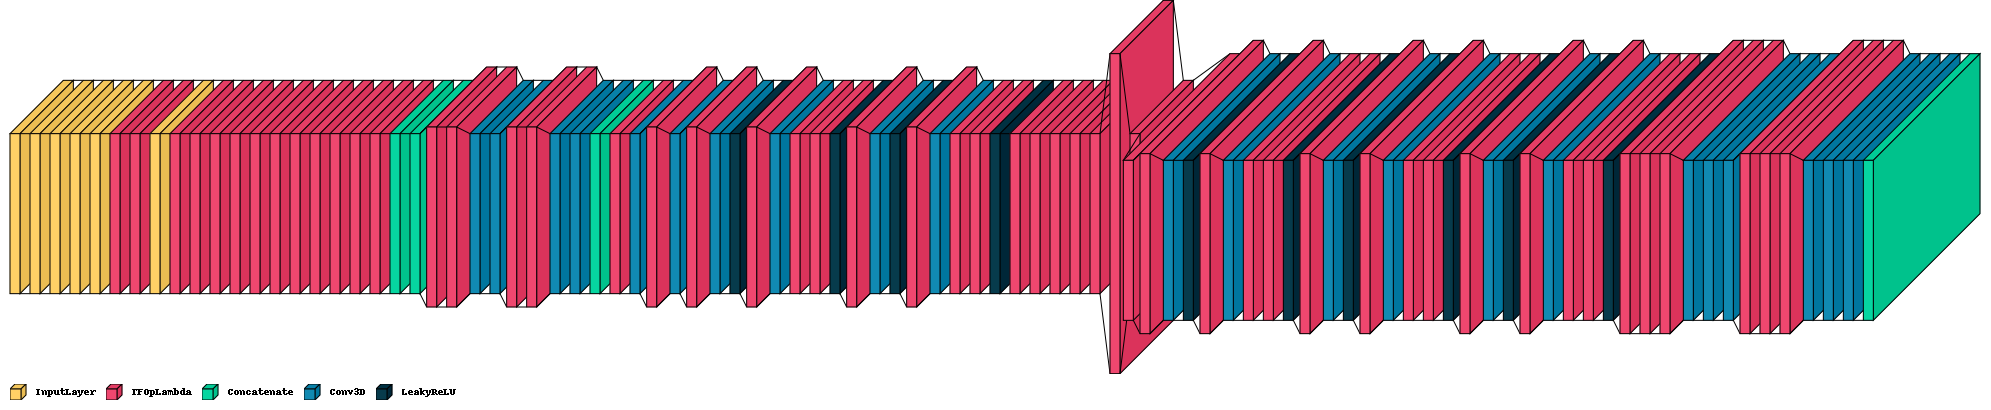

In [13]:
import visualkeras
from collections import defaultdict
from Network.STR4DFlowNet_adapted import STR4DFlowNet

def prepare_temporal_network(patch_size, res_increase, n_low_resblock, n_hi_resblock, low_res_block, high_res_block, upsampling_block, post_processing_block):
    # Prepare input
    input_shape = (patch_size,patch_size,patch_size,1)
    u = tf.keras.layers.Input(shape=input_shape, name='u')
    v = tf.keras.layers.Input(shape=input_shape, name='v')
    w = tf.keras.layers.Input(shape=input_shape, name='w')

    u_mag = tf.keras.layers.Input(shape=input_shape, name='u_mag')
    v_mag = tf.keras.layers.Input(shape=input_shape, name='v_mag')
    w_mag = tf.keras.layers.Input(shape=input_shape, name='w_mag')

    input_layer = [u,v,w,u_mag, v_mag, w_mag]

    # network & output
    net = STR4DFlowNet(res_increase,low_res_block=low_res_block, high_res_block=high_res_block,  upsampling_block=upsampling_block , post_processing_block=post_processing_block)
    prediction = net.build_network(u, v, w, u_mag, v_mag, w_mag, n_low_resblock, n_hi_resblock)
    model = tf.keras.Model(input_layer, prediction)

    return model
from tensorflow.python.keras.layers import Dense, Conv3D, Flatten, Dropout, MaxPooling3D, ZeroPadding3D
color_map = defaultdict(dict)
color_map[Conv3D]['fill'] = 'orange'
color_map[ZeroPadding3D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling3D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'


model = prepare_temporal_network(16, 2, 2, 3, 'resnet_block', 'resnet_block', 'linear', None)
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png', legend = True, color_map=color_map, scale_xy=10, scale_z=1, max_z=10) # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and sho

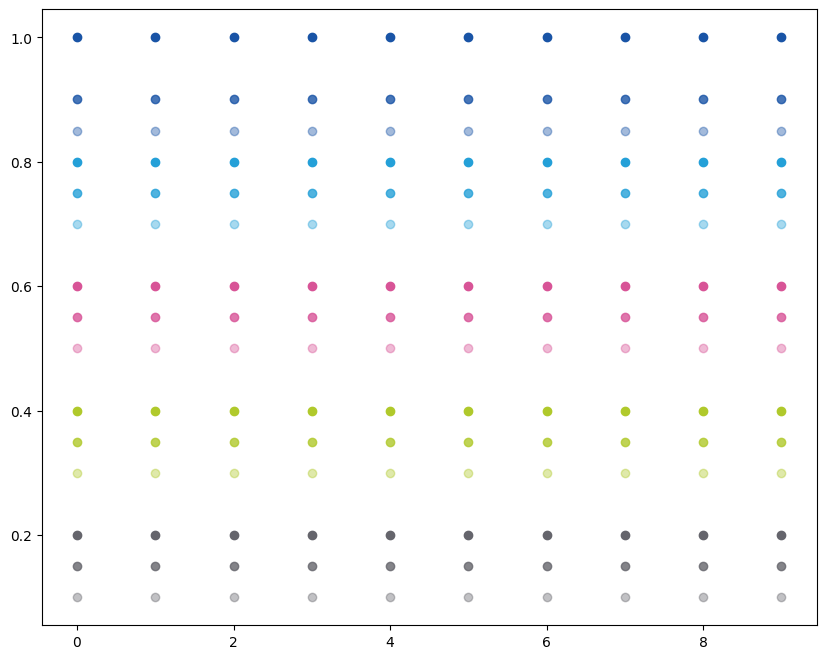

In [21]:
KTH_colors={'blue100' :(25/255, 84/255, 166/255), 'blue80' :(25/255, 84/255, 166/255, 0.8), 'blue40' :(25/255, 84/255, 166/255, 0.4),
            'lightblue100': (36/255, 160/255, 216/255), 'lightblue80': (36/255, 160/255, 216/255, 0.8), 'lightblue40': (36/255, 160/255, 216/255, 0.4),
            'pink100': (216/255, 84/255, 151/255), 'pink80': (216/255, 84/255, 151/255, 0.8), 'pink40': (216/255, 84/255, 151/255, 0.4),
            'green100': (176/255, 201/255, 43/255), 'green80': (176/255, 201/255, 43/255, 0.8), 'green40': (176/255, 201/255, 43/255, 0.4),
            'grey100': (101/255, 101/255, 108/255), 'grey80': (101/255, 101/255, 108/255, 0.8), 'grey40': (101/255, 101/255, 108/255, 0.4),
}


plt.scatter(np.arange(10), np.ones(10), color =KTH_colors['blue100'])
plt.scatter(np.arange(10), np.ones(10)*0.9, color =KTH_colors['blue80'])
plt.scatter(np.arange(10), np.ones(10)*0.85, color =KTH_colors['blue40'])

plt.scatter(np.arange(10), np.ones(10)*0.8, color =KTH_colors['lightblue100'])
plt.scatter(np.arange(10), np.ones(10)*0.75, color =KTH_colors['lightblue80'])
plt.scatter(np.arange(10), np.ones(10)*0.7, color =KTH_colors['lightblue40'])

plt.scatter(np.arange(10), np.ones(10)*0.6, color =KTH_colors['pink100'])
plt.scatter(np.arange(10), np.ones(10)*0.55, color =KTH_colors['pink80'])
plt.scatter(np.arange(10), np.ones(10)*0.5, color =KTH_colors['pink40'])

plt.scatter(np.arange(10), np.ones(10)*0.4, color =KTH_colors['green100'])
plt.scatter(np.arange(10), np.ones(10)*0.35, color =KTH_colors['green80'])
plt.scatter(np.arange(10), np.ones(10)*0.3, color =KTH_colors['green40'])

plt.scatter(np.arange(10), np.ones(10)*0.2, color =KTH_colors['grey100'])
plt.scatter(np.arange(10), np.ones(10)*0.15, color =KTH_colors['grey80'])
plt.scatter(np.arange(10), np.ones(10)*0.1, color =KTH_colors['grey40'])


In [23]:
eval_dir = '../results/in_vivo/VINCENT/' 
vincent_path = '../data/PIA/VINCENT/17.6ms/VINCENT_17_6.h5'
v_data = {}
with h5py.File(vincent_path, mode = 'r' ) as p1:
    print(p1.keys())
    v_data['maybemag'] = np.asarray(p1['maybemag'])
    v_data['maybemag2'] = np.asarray(p1['maybemag2'])
    print(v_data['maybemag'].shape, v_data['maybemag2'].shape)




# plt.imshow(v_data['maybemag'][idx_slice])

@widgets.interact(frame=(0, v_data['maybemag2'].shape[0]-1), x = (0, v_data['maybemag2'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 2, 1)
    idx_slice = np.index_exp[frame, x, :, :]
    plt.imshow(v_data['maybemag2'][idx_slice], cmap= 'Greys_r')
    plt.title('Vincents mag')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(v_data['maybemag'][idx_slice])
    plt.title('Vincents velocity')
    plt.axis('off')

<KeysViewHDF5 ['maybemag', 'maybemag2']>
(48, 56, 154, 224) (48, 56, 154, 224)


interactive(children=(IntSlider(value=5, description='frame', max=47), IntSlider(value=0, description='x', max…

MovieWriter ffmpeg unavailable; using Pillow instead.


Vincent_mag nframes: 48


MovieWriter ffmpeg unavailable; using Pillow instead.


Vincent_v nframes: 48


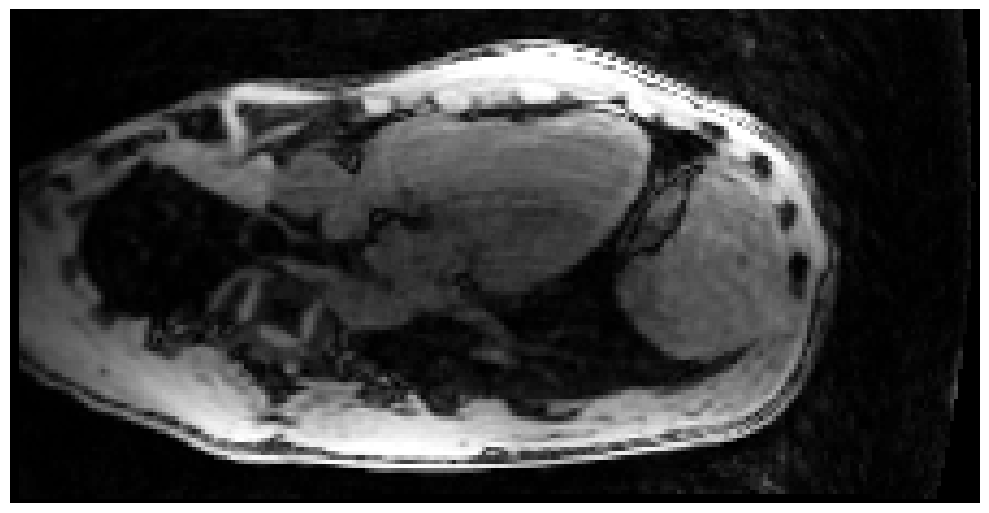

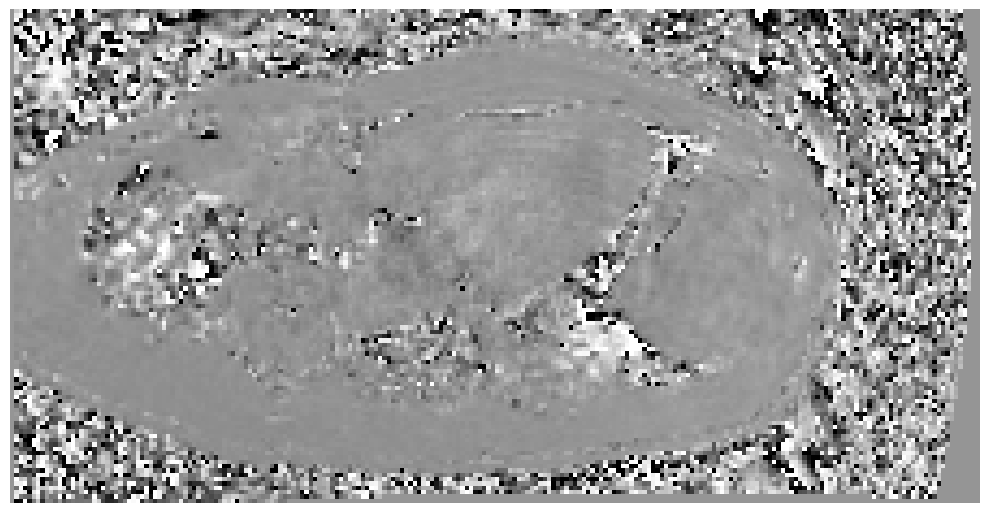

In [38]:
def create_temporal_comparison_gif_single(spatial_idx, data,  min_v, max_v, title, colormap = 'viridis'):

    print(title, 'nframes:', data.shape[0])
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(data[0, spatial_idx[0], spatial_idx[1], spatial_idx[2]],interpolation='none', vmin=min_v, vmax=max_v, cmap = colormap)
    # plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, spatial_idx[0], spatial_idx[1], spatial_idx[2]])
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = data.shape[0],
                                interval = 100, repeat = False) # in ms)
    anim.save(f'{eval_dir}/Animate_invivo_{title}_18_faster2.gif', fps=30)

idx_slice = np.index_exp[ 30, 40:, :]
create_temporal_comparison_gif_single(idx_slice, v_data['maybemag2'], 0, np.quantile(v_data['maybemag2'][10], 0.99), title=f'Vincent_mag', colormap='Greys_r' )
create_temporal_comparison_gif_single(idx_slice, v_data['maybemag'], np.quantile(v_data['maybemag'][10,  idx_slice[0], idx_slice[1], idx_slice[2]], 0.01), np.quantile(v_data['maybemag'][10,  idx_slice[0], idx_slice[1], idx_slice[2]], 0.99), title=f'Vincent_v', colormap='Greys_r' )